# Naive Bayes y Pipelines para Clasificación de Texto

**Materiales desarrollados por Matías Barreto, 2025**

**Tecnicatura en Ciencia de Datos - IFTS**

**Asignatura:** Procesamiento de Lenguaje Natural

---

## Introducción

En este notebook vamos a profundizar en dos conceptos fundamentales para el trabajo profesional en Machine Learning:

1. **Naive Bayes**: Un algoritmo probabilístico clásico que fue piedra angular en clasificación de texto (spam detection, sentiment analysis) antes de la era del deep learning.

2. **Pipelines**: Una forma elegante y profesional de encadenar transformaciones y modelos, facilitando reproducibilidad y despliegue.

### Objetivos de aprendizaje

1. Comprender el teorema de Bayes y su aplicación en clasificación de texto
2. Implementar clasificadores Naive Bayes con sklearn
3. Dominar el concepto de Pipeline para flujos de trabajo modulares
4. Interpretar métricas avanzadas: precision, recall, F1-score
5. Analizar matrices de confusión para detectar patrones de error
6. Trabajar con datos en español rioplatense

### ¿Por qué es importante este notebook?

Los pipelines son el estándar en la industria para organizar código de ML. Además, las métricas que vamos a estudiar (precision, recall, F1) son las mismas que usaremos más adelante para evaluar modelos de transformers en tareas de fine-tuning.

---

## 1. Importación de Librerías

Importamos las herramientas necesarias, incluyendo componentes para construir pipelines y visualizar resultados.

In [1]:
# Librería para manipulación de arrays numéricos
import numpy as np

# Librería para manipulación de datos tabulares
import pandas as pd

# Vectorizadores de texto
# CountVectorizer: Convierte texto en matriz de conteos (Bag of Words)
# TfidfVectorizer: Convierte texto en matriz TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# División de datos y validación cruzada
from sklearn.model_selection import train_test_split, cross_val_score

# Pipeline: Encadena múltiples pasos (transformación + modelo)
from sklearn.pipeline import Pipeline

# Clasificadores
# MultinomialNB: Naive Bayes para features discretas (conteos de palabras)
# LogisticRegression: Para comparación con el notebook anterior
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Métricas de evaluación
# classification_report: Precision, recall, F1-score por clase
# confusion_matrix: Matriz de verdaderos/falsos positivos/negativos
# ConfusionMatrixDisplay: Visualización gráfica de la matriz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Librería para visualización
import matplotlib.pyplot as plt

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


---

## 2. Dataset en Español Rioplatense

A diferencia del notebook anterior (que usó reseñas en inglés), ahora vamos a trabajar con textos en **español rioplatense**. Esto es importante porque:

1. Refleja el contexto local argentino
2. Introduce vocabulario coloquial ("quilombo", "onda", "banda", "zafar")
3. Prepara para trabajar con datasets locales en proyectos reales

Vamos a crear un pequeño corpus de reseñas de restaurantes y servicios en Buenos Aires.

In [2]:
# Corpus de reseñas en español rioplatense
# Etiqueta: 1 = Positivo, 0 = Negativo
textos = [
    # Positivas
    "La milanesa a caballo estaba espectacular, muy recomendable.",
    "Qué buena onda la atención, volvería sin dudarlo.",
    "El flan con dulce de leche es lo más, quedé re contento.",
    "Excelente servicio, todo impecable y rápido.",
    "Me encantó el lugar, súper tranquilo y con buena música.",
    "La verdad que zafa y está bien de precio.",
    "Muy copado el ambiente, te sentís como en casa.",
    "El mejor asado que probé en mucho tiempo, de diez.",
    "Pedí empanadas y llegaron calentitas, re bien.",
    "Atención de primera, te explican todo con paciencia.",

    # Negativas
    "El bife de chorizo llegó frío y duro, una decepción.",
    "Mucho quilombo, tardaron una banda en traer la cuenta.",
    "La verdad, la pizza dejaba bastante que desear.",
    "Pésima atención, el mozo tenía mala onda.",
    "No vuelvo más, carísimo y la comida era un desastre.",
    "Tardaron dos horas en entregar, llegó todo frío.",
    "El lugar es un desastre, sucio y con olor raro.",
    "Me cobraron de más y encima se hicieron los giles.",
    "La carne estaba pasada, casi no se podía comer.",
    "Malísima experiencia, no lo recomiendo para nada."
]

# Etiquetas correspondientes (1=positivo, 0=negativo)
etiquetas = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 10 positivas
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # 10 negativas

# Creamos un DataFrame para visualizar mejor
df = pd.DataFrame({
    'texto': textos,
    'sentimiento': etiquetas,
    'etiqueta_texto': ['Positivo' if e == 1 else 'Negativo' for e in etiquetas]
})

print(f"Total de reseñas: {len(df)}")
print(f"\nDistribución de clases:")
print(df['etiqueta_texto'].value_counts())
print(f"\nPrimeras 5 reseñas:")
df.head()

Total de reseñas: 20

Distribución de clases:
etiqueta_texto
Positivo    10
Negativo    10
Name: count, dtype: int64

Primeras 5 reseñas:


,texto,sentimiento,etiqueta_texto
0,"La milanesa a caballo estaba espectacular, muy...",1,Positivo
1,"Qué buena onda la atención, volvería sin dudarlo.",1,Positivo
2,"El flan con dulce de leche es lo más, quedé re...",1,Positivo
3,"Excelente servicio, todo impecable y rápido.",1,Positivo
4,"Me encantó el lugar, súper tranquilo y con bue...",1,Positivo


---

## 3. División en Conjuntos de Entrenamiento y Prueba

Separamos los datos para entrenamiento y evaluación. Con datasets pequeños como este, usamos una proporción 70/30 en lugar de 80/20.

In [3]:
# Separamos características (X) y etiquetas (y)
X = df['texto'].values
y = df['sentimiento'].values

# División 70% entrenamiento, 30% prueba
# stratify=y asegura que ambos conjuntos tengan la misma proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print(f"Conjunto de entrenamiento: {len(X_train)} reseñas")
print(f"Conjunto de prueba: {len(X_test)} reseñas")
print(f"\nDistribución en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución en prueba: {np.bincount(y_test)}")

Conjunto de entrenamiento: 14 reseñas
Conjunto de prueba: 6 reseñas

Distribución en entrenamiento: [7 7]
Distribución en prueba: [3 3]


---

## 4. Naive Bayes: Fundamentos Teóricos

### El Teorema de Bayes

Naive Bayes se basa en el teorema de Bayes:

$$P(clase | documento) = \frac{P(documento | clase) \times P(clase)}{P(documento)}$$

**Interpretación en nuestro contexto:**
- **P(clase | documento)**: Probabilidad de que una reseña sea positiva/negativa dado su texto
- **P(documento | clase)**: Probabilidad de observar ese texto en reseñas positivas/negativas
- **P(clase)**: Probabilidad a priori de cada clase (frecuencia en el dataset)
- **P(documento)**: Probabilidad del documento (constante, se puede ignorar)

### La Suposición "Naive" (Ingenua)

El algoritmo asume **independencia condicional** entre las palabras:

$$P(documento | clase) = P(palabra_1 | clase) \times P(palabra_2 | clase) \times ... \times P(palabra_n | clase)$$

**¿Por qué es "naive"?** Porque en realidad las palabras NO son independientes ("muy bueno" tiene más sentido que "muy" y "bueno" por separado). Sin embargo, en la práctica funciona sorprendentemente bien.

### Multinomial Naive Bayes

Para clasificación de texto con conteos de palabras, usamos **MultinomialNB**, que modela la distribución multinomial de las palabras en cada clase.

---

## 5. Entrenamiento Manual (sin Pipeline)

Primero entrenamos el modelo de la forma tradicional, paso por paso, para entender el flujo.

In [4]:
# Paso 1: Vectorización
# Usamos TF-IDF con unigramas y bigramas
# ngram_range=(1,2) captura palabras individuales y pares de palabras
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Forma de la matriz de entrenamiento: {X_train_vec.shape}")
print(f"Vocabulario construido con {len(vectorizer.get_feature_names_out())} features")

# Paso 2: Entrenamiento del modelo Naive Bayes
# alpha=1.0 es el parámetro de suavizado de Laplace (evita probabilidades cero)
clf_nb = MultinomialNB(alpha=1.0)
clf_nb.fit(X_train_vec, y_train)

print("\nModelo Naive Bayes entrenado.")

# Paso 3: Predicción
y_pred = clf_nb.predict(X_test_vec)

# Paso 4: Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f} ({accuracy*100:.2f}%)")

Forma de la matriz de entrenamiento: (14, 100)
Vocabulario construido con 100 features

Modelo Naive Bayes entrenado.

Accuracy en el conjunto de prueba: 0.5000 (50.00%)


---

## 6. Pipelines: La Forma Profesional

Los **Pipelines** de sklearn encadenan transformaciones y modelos en un solo objeto. Esto tiene múltiples ventajas:

### Ventajas de usar Pipelines

1. **Código más limpio**: Todo en un objeto, menos variables temporales
2. **Prevención de data leakage**: Garantiza que fit() solo se llame en train
3. **Reproducibilidad**: Un objeto contiene todo el flujo
4. **Facilita despliegue**: Guardas un solo objeto con pickle/joblib
5. **Grid search más simple**: Buscar hiperparámetros de todo el pipeline

### Sintaxis de Pipeline

```python
Pipeline([
    ('nombre_paso1', transformador1),
    ('nombre_paso2', transformador2),
    ('nombre_modelo', modelo)
])
```

In [5]:
# Creamos un Pipeline que encadena TF-IDF + Naive Bayes
pipeline_nb = Pipeline([
    # Paso 1: Vectorización con TF-IDF
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=100)),

    # Paso 2: Clasificador Naive Bayes
    ('clf', MultinomialNB(alpha=1.0))
])

print("Pipeline creado:")
print(pipeline_nb)

# Entrenamos el pipeline completo con una sola llamada a fit()
# Internamente, hace tfidf.fit_transform() seguido de clf.fit()
print("\nEntrenando pipeline...")
pipeline_nb.fit(X_train, y_train)
print("Pipeline entrenado.")

# Predicción con el pipeline
# Internamente, hace tfidf.transform() seguido de clf.predict()
y_pred_pipeline = pipeline_nb.predict(X_test)

# Evaluación
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print(f"\nAccuracy del pipeline: {accuracy_pipeline:.4f} ({accuracy_pipeline*100:.2f}%)")

Pipeline creado:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

Entrenando pipeline...
Pipeline entrenado.

Accuracy del pipeline: 0.5000 (50.00%)


### Comparación: Pipeline vs. Forma Manual

Veamos la diferencia de código:

In [6]:
print("="*60)
print("FORMA MANUAL (múltiples pasos)")
print("="*60)
print("""
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)
""")

print("\n" + "="*60)
print("FORMA PIPELINE (todo en uno)")
print("="*60)
print("""
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
""")

print("\n¡Mucho más limpio y profesional!")

FORMA MANUAL (múltiples pasos)

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)


FORMA PIPELINE (todo en uno)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


¡Mucho más limpio y profesional!


---

## 7. Métricas Avanzadas: Más Allá del Accuracy

El accuracy solo nos dice el porcentaje de aciertos totales, pero no nos muestra dónde falla el modelo. Para eso usamos:

### Precision (Precisión)
$$\text{Precision} = \frac{\text{Verdaderos Positivos}}{\text{Verdaderos Positivos + Falsos Positivos}}$$

**Pregunta que responde:** De todas las reseñas que predijimos como positivas, ¿cuántas lo eran realmente?

**Importante cuando:** El costo de falsos positivos es alto (ej: aprobar un spam como legítimo)

### Recall (Exhaustividad)
$$\text{Recall} = \frac{\text{Verdaderos Positivos}}{\text{Verdaderos Positivos + Falsos Negativos}}$$

**Pregunta que responde:** De todas las reseñas positivas reales, ¿cuántas detectamos?

**Importante cuando:** El costo de falsos negativos es alto (ej: detectar fraude)

### F1-Score
$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}$$

**Interpretación:** Media armónica entre precision y recall. Útil cuando necesitamos balance entre ambas.

In [7]:
# Reporte de clasificación completo
print("="*60)
print("REPORTE DE CLASIFICACIÓN - NAIVE BAYES")
print("="*60)
print(classification_report(y_test, y_pred_pipeline,
                          target_names=['Negativo', 'Positivo'],
                          digits=4))

print("\nInterpretación de las columnas:")
print("-" * 60)
print("precision: De las predicciones de esa clase, ¿cuántas eran correctas?")
print("recall:    De los ejemplos reales de esa clase, ¿cuántos detectamos?")
print("f1-score:  Balance entre precision y recall")
print("support:   Cantidad de ejemplos de esa clase en el conjunto de prueba")

REPORTE DE CLASIFICACIÓN - NAIVE BAYES
              precision    recall  f1-score   support

    Negativo     0.5000    0.3333    0.4000         3
    Positivo     0.5000    0.6667    0.5714         3

    accuracy                         0.5000         6
   macro avg     0.5000    0.5000    0.4857         6
weighted avg     0.5000    0.5000    0.4857         6


Interpretación de las columnas:
------------------------------------------------------------
precision: De las predicciones de esa clase, ¿cuántas eran correctas?
recall:    De los ejemplos reales de esa clase, ¿cuántos detectamos?
f1-score:  Balance entre precision y recall
support:   Cantidad de ejemplos de esa clase en el conjunto de prueba


---

## 8. Matriz de Confusión: Visualizando Errores

La matriz de confusión muestra en detalle cómo el modelo clasifica cada instancia:

```
                    Predicho Negativo    Predicho Positivo
Real Negativo              TN                   FP
Real Positivo              FN                   TP
```

- **TN (True Negative)**: Negativos correctamente clasificados
- **TP (True Positive)**: Positivos correctamente clasificados
- **FP (False Positive)**: Negativos clasificados erróneamente como positivos (Error Tipo I)
- **FN (False Negative)**: Positivos clasificados erróneamente como negativos (Error Tipo II)

MATRIZ DE CONFUSIÓN
[[1 2]
 [1 2]]

Desglose:
Verdaderos Negativos (TN): 1 - Negativos correctamente clasificados
Falsos Positivos (FP):     2 - Negativos clasificados como positivos (ERROR)
Falsos Negativos (FN):     1 - Positivos clasificados como negativos (ERROR)
Verdaderos Positivos (TP): 2 - Positivos correctamente clasificados


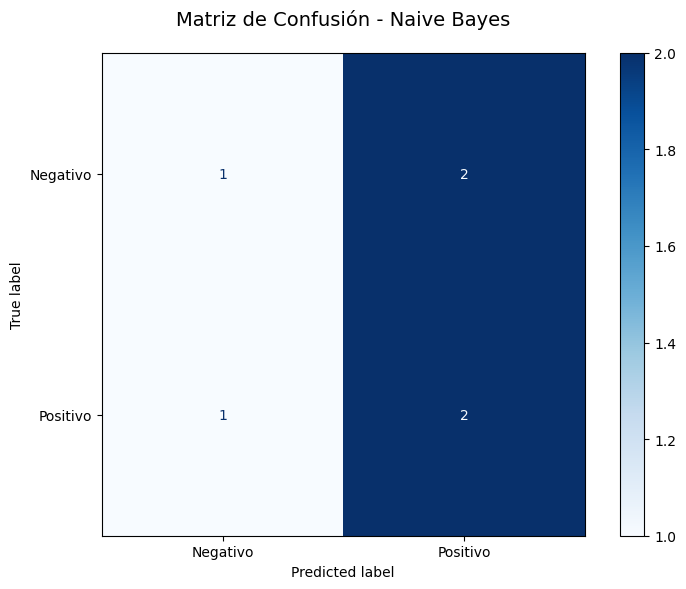


Lectura de la matriz:
- La diagonal principal (arriba-izquierda a abajo-derecha) son los ACIERTOS
- Los valores fuera de la diagonal son los ERRORES
- Idealmente, la diagonal debe ser oscura y el resto claro


In [8]:
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred_pipeline)

print("MATRIZ DE CONFUSIÓN")
print("="*60)
print(cm)
print("\nDesglose:")
print(f"Verdaderos Negativos (TN): {cm[0,0]} - Negativos correctamente clasificados")
print(f"Falsos Positivos (FP):     {cm[0,1]} - Negativos clasificados como positivos (ERROR)")
print(f"Falsos Negativos (FN):     {cm[1,0]} - Positivos clasificados como negativos (ERROR)")
print(f"Verdaderos Positivos (TP): {cm[1,1]} - Positivos correctamente clasificados")

# Visualización gráfica
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Negativo', 'Positivo'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Matriz de Confusión - Naive Bayes', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nLectura de la matriz:")
print("- La diagonal principal (arriba-izquierda a abajo-derecha) son los ACIERTOS")
print("- Los valores fuera de la diagonal son los ERRORES")
print("- Idealmente, la diagonal debe ser oscura y el resto claro")

---

## 9. Comparación: Naive Bayes vs. Regresión Logística

Creamos un segundo pipeline con Regresión Logística para comparar rendimiento.

In [9]:
# Pipeline con Regresión Logística
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=100)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenamiento
print("Entrenando pipeline con Regresión Logística...")
pipeline_lr.fit(X_train, y_train)
print("Pipeline entrenado.\n")

# Predicciones
y_pred_lr = pipeline_lr.predict(X_test)

# Comparación de resultados
print("="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

print("\nNAIVE BAYES:")
print("-" * 60)
print(classification_report(y_test, y_pred_pipeline,
                          target_names=['Negativo', 'Positivo'],
                          digits=4))

print("\nREGRESIÓN LOGÍSTICA:")
print("-" * 60)
print(classification_report(y_test, y_pred_lr,
                          target_names=['Negativo', 'Positivo'],
                          digits=4))

Entrenando pipeline con Regresión Logística...
Pipeline entrenado.

COMPARACIÓN DE MODELOS

NAIVE BAYES:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negativo     0.5000    0.3333    0.4000         3
    Positivo     0.5000    0.6667    0.5714         3

    accuracy                         0.5000         6
   macro avg     0.5000    0.5000    0.4857         6
weighted avg     0.5000    0.5000    0.4857         6


REGRESIÓN LOGÍSTICA:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negativo     0.5000    0.3333    0.4000         3
    Positivo     0.5000    0.6667    0.5714         3

    accuracy                         0.5000         6
   macro avg     0.5000    0.5000    0.4857         6
weighted avg     0.5000    0.5000    0.4857         6



---

## 10. Análisis de Errores: ¿Qué Clasificó Mal el Modelo?

Una parte fundamental del trabajo de Data Science es analizar qué casos el modelo clasifica incorrectamente para entender sus limitaciones.

In [10]:
# Identificamos las reseñas mal clasificadas
errores = X_test[y_test != y_pred_pipeline]
etiquetas_reales = y_test[y_test != y_pred_pipeline]
etiquetas_predichas = y_pred_pipeline[y_test != y_pred_pipeline]

if len(errores) > 0:
    print("="*80)
    print("ANÁLISIS DE ERRORES")
    print("="*80)
    print(f"\nTotal de errores: {len(errores)} de {len(X_test)} ({len(errores)/len(X_test)*100:.1f}%)\n")

    for i, (texto, real, pred) in enumerate(zip(errores, etiquetas_reales, etiquetas_predichas), 1):
        real_label = "Positivo" if real == 1 else "Negativo"
        pred_label = "Positivo" if pred == 1 else "Negativo"

        print(f"Error #{i}:")
        print(f"Texto: \"{texto}\"")
        print(f"Etiqueta real: {real_label}")
        print(f"Predicción: {pred_label}")
        print("-" * 80)
else:
    print("¡Clasificación perfecta! No hubo errores en el conjunto de prueba.")

ANÁLISIS DE ERRORES

Total de errores: 3 de 6 (50.0%)

Error #1:
Texto: "Pésima atención, el mozo tenía mala onda."
Etiqueta real: Negativo
Predicción: Positivo
--------------------------------------------------------------------------------
Error #2:
Texto: "El flan con dulce de leche es lo más, quedé re contento."
Etiqueta real: Positivo
Predicción: Negativo
--------------------------------------------------------------------------------
Error #3:
Texto: "El lugar es un desastre, sucio y con olor raro."
Etiqueta real: Negativo
Predicción: Positivo
--------------------------------------------------------------------------------


---

## 11. Predicciones sobre Textos Nuevos

Ahora probamos el modelo con reseñas nuevas que nunca vio.

In [11]:
# Nuevas reseñas para clasificar
nuevas_reseñas = [
    "La verdad que el lugar está buenísimo, muy recomendable.",
    "Malísimo todo, no vuelvo nunca más.",
    "Está bien, nada del otro mundo pero safable.",
    "Pedí delivery y llegó todo perfecto, muy contento.",
    "Una porquería, carísimo y la comida fría.",
    "Qué buena atención, volvería sin dudarlo."
]

# Predicciones con el pipeline (automáticamente vectoriza y clasifica)
predicciones = pipeline_nb.predict(nuevas_reseñas)

# También obtenemos probabilidades
probabilidades = pipeline_nb.predict_proba(nuevas_reseñas)

# Mostramos resultados
print("="*80)
print("PREDICCIONES SOBRE RESEÑAS NUEVAS")
print("="*80)

for i, reseña in enumerate(nuevas_reseñas):
    sentimiento = "POSITIVO" if predicciones[i] == 1 else "NEGATIVO"
    prob_neg = probabilidades[i][0] * 100
    prob_pos = probabilidades[i][1] * 100

    print(f"\nReseña: \"{reseña}\"")
    print(f"Predicción: {sentimiento}")
    print(f"Probabilidades: Negativo={prob_neg:.2f}%, Positivo={prob_pos:.2f}%")

PREDICCIONES SOBRE RESEÑAS NUEVAS

Reseña: "La verdad que el lugar está buenísimo, muy recomendable."
Predicción: POSITIVO
Probabilidades: Negativo=35.76%, Positivo=64.24%

Reseña: "Malísimo todo, no vuelvo nunca más."
Predicción: NEGATIVO
Probabilidades: Negativo=56.50%, Positivo=43.50%

Reseña: "Está bien, nada del otro mundo pero safable."
Predicción: POSITIVO
Probabilidades: Negativo=33.76%, Positivo=66.24%

Reseña: "Pedí delivery y llegó todo perfecto, muy contento."
Predicción: NEGATIVO
Probabilidades: Negativo=56.90%, Positivo=43.10%

Reseña: "Una porquería, carísimo y la comida fría."
Predicción: NEGATIVO
Probabilidades: Negativo=58.42%, Positivo=41.58%

Reseña: "Qué buena atención, volvería sin dudarlo."
Predicción: POSITIVO
Probabilidades: Negativo=30.72%, Positivo=69.28%


---

## 12. Validación Cruzada: Evaluación Más Robusta

Con datasets pequeños, una sola división train/test puede ser engañosa. La **validación cruzada** (cross-validation) divide los datos en k partes y entrena k veces, usando cada parte como test una vez.

### K-Fold Cross-Validation

1. Dividir datos en k "folds" (pliegues)
2. Para cada fold:
   - Usar ese fold como test
   - Usar los k-1 restantes como train
   - Entrenar y evaluar
3. Promediar los k resultados

Esto da una estimación más estable del rendimiento real del modelo.

In [ ]:
# Validación cruzada con 5 folds
# cv=5 significa que dividirá los datos en 5 partes
print("Ejecutando validación cruzada con 5 folds...\n")

scores_nb = cross_val_score(pipeline_nb, X, y, cv=5, scoring='accuracy')
scores_lr = cross_val_score(pipeline_lr, X, y, cv=5, scoring='accuracy')

print("="*60)
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print("="*60)

print("\nNAIVE BAYES:")
print(f"Scores por fold: {scores_nb}")
print(f"Media: {scores_nb.mean():.4f}")
print(f"Desviación estándar: {scores_nb.std():.4f}")

print("\nREGRESIÓN LOGÍSTICA:")
print(f"Scores por fold: {scores_lr}")
print(f"Media: {scores_lr.mean():.4f}")
print(f"Desviación estándar: {scores_lr.std():.4f}")

print("\n" + "="*60)
print("Interpretación:")
print("-" * 60)
print("- La media es el rendimiento esperado del modelo")
print("- Una desviación estándar baja indica consistencia")
print("- Desviación alta sugiere que el modelo es sensible a la división de datos")

---

## Guía Teórico-Conceptual

### 1. Naive Bayes: Ventajas y Limitaciones

**Ventajas:**
- Muy rápido de entrenar y predecir
- Requiere poca memoria
- Funciona bien con datasets pequeños
- Probabilísticamente interpretable
- No requiere ajuste de hiperparámetros
- Históricamente exitoso en spam detection y sentiment analysis

**Limitaciones:**
- La suposición de independencia es irreal (palabras están correlacionadas)
- No captura orden de palabras ni contexto
- Puede ser superado por modelos más sofisticados con suficientes datos
- Sensible a features irrelevantes

### 2. Pipelines en Producción

**Flujo típico en la industria:**

```python
# 1. Desarrollo
pipeline = Pipeline([
    ('preprocesamiento', CustomTransformer()),
    ('vectorizacion', TfidfVectorizer()),
    ('modelo', LogisticRegression())
])
pipeline.fit(X_train, y_train)

# 2. Guardado
import joblib
joblib.dump(pipeline, 'modelo_produccion.pkl')

# 3. Despliegue (en servidor/API)
pipeline = joblib.load('modelo_produccion.pkl')
prediccion = pipeline.predict([texto_nuevo])
```

**Ventajas en producción:**
- Un solo archivo contiene todo el flujo
- No hay riesgo de inconsistencias entre train y producción
- Fácil versionado y rollback
- Integración simple con APIs (Flask, FastAPI)

### 3. Precision vs. Recall: Trade-off

**Ejemplo: Detector de spam**

**Escenario A: Maximizar Precision**
- Solo marcamos como spam cuando estamos MUY seguros
- Pocos falsos positivos (emails legítimos marcados como spam)
- Pero dejamos pasar más spam (falsos negativos)
- Prioridad: No molestar al usuario con clasificaciones erróneas

**Escenario B: Maximizar Recall**
- Marcamos como spam con menor umbral
- Capturamos casi todo el spam (pocos falsos negativos)
- Pero más emails legítimos van a spam (falsos positivos)
- Prioridad: Limpiar la bandeja de entrada

**F1-Score:** Busca el balance óptimo entre ambos

### 4. Matriz de Confusión: Interpretación Avanzada

**Patrones comunes:**

1. **Diagonal dominante:** Buen modelo
2. **Columna positiva grande:** Modelo tiende a predecir positivo (bias)
3. **Fila positiva grande:** El modelo "pierde" muchos positivos reales
4. **Matriz simétrica:** Errores balanceados entre clases
5. **Matriz asimétrica:** El modelo confunde más una dirección que otra

**Aplicación práctica:**
- Si FP es alto: El modelo es "optimista" (clasifica positivo de más)
- Si FN es alto: El modelo es "pesimista" (clasifica negativo de más)
- Ajustando el umbral de probabilidad podemos mover el trade-off

### 5. Validación Cruzada: ¿Cuándo Usarla?

**Usar cross-validation cuando:**
- Dataset pequeño (< 1000 muestras)
- Queremos estimar varianza del modelo
- Estamos en fase de selección de modelo
- Necesitamos reportar métricas confiables

**NO usar cross-validation cuando:**
- Dataset muy grande (costoso computacionalmente)
- Datos tienen estructura temporal (usar split temporal)
- Ya estamos en fase de producción

### 6. Suavizado de Laplace en Naive Bayes

El parámetro `alpha` en MultinomialNB es el suavizado de Laplace:

**Problema:** Si una palabra nunca aparece con una clase en training, su probabilidad es 0, y todo el producto se hace 0.

**Solución:** Agregar un pequeño valor (alpha) a todos los conteos:

$$P(palabra | clase) = \frac{count(palabra, clase) + \alpha}{count(clase) + \alpha \times |vocabulario|}$$

- `alpha=1.0` (default): Suavizado uniforme
- `alpha<1.0`: Menos suavizado (confía más en los datos)
- `alpha>1.0`: Más suavizado (más regularización)

### 7. N-gramas: Capturando Contexto Local

**Unigramas (n=1):** Palabras individuales
- Ejemplo: ["no", "me", "gusta"]
- Ignora orden completamente

**Bigramas (n=2):** Pares de palabras consecutivas
- Ejemplo: ["no me", "me gusta"]
- Captura algunas negaciones y frases comunes

**Trigramas (n=3):** Tripletas de palabras
- Ejemplo: ["no me gusta"]
- Más contexto pero vocabulario explota (curse of dimensionality)

**Trade-off:**
- Más n-gramas = más contexto pero más features
- Con datasets pequeños, n>2 suele causar overfitting
- `ngram_range=(1,2)` es un buen balance

---

## Preguntas y Respuestas para Estudio

### Preguntas Conceptuales

**1. ¿Por qué se llama "Naive" (ingenuo) Bayes?**

*Respuesta:* Porque asume que todas las palabras son independientes entre sí, lo cual es una suposición simplificadora (naive). En realidad, las palabras están correlacionadas ("muy bueno" tiene más sentido que "muy" y "bueno" por separado), pero esta simplificación hace que el algoritmo sea muy eficiente sin perder demasiada precisión.

**2. ¿Cuál es la diferencia entre Multinomial y Gaussian Naive Bayes?**

*Respuesta:* MultinomialNB está diseñado para features discretas (conteos de palabras), modelando una distribución multinomial. GaussianNB es para features continuas, asumiendo distribución normal. Para clasificación de texto con BoW/TF-IDF, siempre usamos MultinomialNB.

**3. ¿Qué es el suavizado de Laplace y por qué es necesario?**

*Respuesta:* Es agregar un pequeño valor (alpha) a todos los conteos para evitar probabilidades cero. Si una palabra nunca apareció con una clase en training, sin suavizado su probabilidad sería 0, haciendo que todo el producto P(documento|clase) sea 0. El suavizado previene este problema.

**4. ¿Por qué los pipelines son importantes en la industria?**

*Respuesta:* Porque encapsulan todo el flujo (preprocesamiento + modelo) en un objeto serializable. Esto garantiza que el mismo preprocesamiento usado en training se aplique en producción, evita data leakage, facilita versionado y simplifica despliegue. Un error común es usar transformaciones diferentes entre desarrollo y producción.

**5. ¿Cuándo preferirías maximizar precision sobre recall?**

*Respuesta:* Cuando el costo de falsos positivos es alto. Ejemplos: (1) Sistema de recomendación de cirugías (no queremos recomendar operaciones innecesarias), (2) Detector de spam agresivo (preferimos dejar pasar spam que bloquear emails legítimos), (3) Sistema de préstamos bancarios (mejor rechazar clientes buenos que aprobar morosos).

### Preguntas Técnicas

**6. ¿Qué información aporta la matriz de confusión que el accuracy no muestra?**

*Respuesta:* La matriz muestra dónde falla el modelo: (1) Si confunde más una clase que otra, (2) Si tiene bias hacia predecir cierta clase, (3) La distribución de errores (FP vs FN). Con accuracy solo sabemos el porcentaje total de aciertos, sin visibilidad del comportamiento por clase.

**7. En el código del pipeline, ¿por qué usamos fit() en X_train (texto crudo) y no en X_train_vec (vectorizado)?**

*Respuesta:* Porque el pipeline encapsula la vectorización. Cuando llamamos `pipeline.fit(X_train, y_train)`, internamente hace: (1) `tfidf.fit_transform(X_train)` para construir vocabulario y vectorizar, (2) `clf.fit(X_train_vec, y_train)` con los datos ya vectorizados. Esto garantiza consistencia.

**8. ¿Qué significa que MultinomialNB devuelva probabilidades? ¿Son confiables?**

*Respuesta:* `predict_proba()` retorna P(clase|documento) según el teorema de Bayes. Aunque las probabilidades no están perfectamente calibradas (a diferencia de Regresión Logística), son útiles para: (1) Establecer umbrales personalizados, (2) Ordenar predicciones por confianza, (3) Identificar casos ambiguos.

**9. ¿Por qué stratify=y en train_test_split?**

*Respuesta:* Para mantener la misma proporción de clases en train y test que en el dataset original. Sin stratify, podríamos tener mala suerte y que test tenga 80% de positivos cuando el dataset tiene 50%, sesgando la evaluación. Especialmente importante con datasets pequeños o desbalanceados.

**10. ¿Qué pasa si usamos fit() en lugar de transform() en los datos de prueba?**

*Respuesta:* Sería un error gravísimo llamado "data leakage". El vectorizador aprendería vocabulario de los datos de prueba, "espiando" información que el modelo no debería conocer. Esto invalida la evaluación. SIEMPRE: fit() solo en train, transform() en test.

### Preguntas de Aplicación

**11. Si tuvieras un dataset con 95% clase negativa y 5% positiva, ¿qué ajustes harías?**

*Respuesta:*
1. NO usar accuracy como métrica principal (un modelo dummy que predice siempre negativo tendría 95% accuracy)
2. Usar F1-score, precision y recall para la clase minoritaria
3. Considerar técnicas de balanceo: undersampling de mayoritaria, oversampling de minoritaria (SMOTE), o ajustar class_weight en el modelo
4. Usar stratified k-fold para garantizar que todos los folds tengan la clase minoritaria

**12. ¿En qué casos Naive Bayes podría superar a Regresión Logística?**

*Respuesta:*
1. Datasets MUY pequeños (< 100 muestras)
2. Cuando hay muchas features y pocas muestras (alta dimensionalidad)
3. Cuando las suposiciones de Naive Bayes se cumplen razonablemente
4. Cuando necesitamos entrenar rapidísimo (NB es más rápido)
5. En dominios donde la independencia de features es aproximadamente correcta

**13. Describí el flujo completo desde notebook hasta producción usando pipelines.**

*Respuesta:*
```python
# 1. Desarrollo (notebook)
pipeline = Pipeline([...])  
pipeline.fit(X_train, y_train)
evaluar_modelo(pipeline, X_test, y_test)

# 2. Serialización
import joblib
joblib.dump(pipeline, 'modelo_v1.pkl')

# 3. API (servidor)
from fastapi import FastAPI
modelo = joblib.load('modelo_v1.pkl')

@app.post("/predict")
def predict(texto: str):
    pred = modelo.predict([texto])[0]
    prob = modelo.predict_proba([texto])[0]
    return {"prediccion": pred, "probabilidad": prob}
```

**14. ¿Cómo interpretarías una matriz de confusión donde FP >> FN?**

*Respuesta:* El modelo es "optimista" (clasifica positivo de más). Muchos casos negativos reales son clasificados erróneamente como positivos. Esto indica:
- Alta recall para clase positiva (detecta casi todos los positivos)
- Baja precision para clase positiva (muchas predicciones positivas son incorrectas)
- Posible solución: Aumentar el umbral de probabilidad para clasificar como positivo

**15. Si validation accuracy es 90% pero train accuracy es 99%, ¿qué está pasando?**

*Respuesta:* **Overfitting**. El modelo memorizó los datos de entrenamiento pero generaliza peor. Soluciones:
1. Reducir max_features (vocabulario más pequeño)
2. Aumentar regularización (alpha en NB, C en LogReg)
3. Usar n-gramas más simples (solo unigramas)
4. Conseguir más datos de entrenamiento
5. Aplicar técnicas de regularización más agresivas

---

## Ejercicios Propuestos

### Ejercicio 1: Experimentación con Alpha
Probá valores de alpha en MultinomialNB: 0.1, 0.5, 1.0, 5.0, 10.0. Graficá cómo cambia el accuracy. ¿Cuál es el valor óptimo para este dataset?

### Ejercicio 2: Impacto de N-gramas
Compará tres configuraciones: (1) solo unigramas, (2) unigramas + bigramas, (3) unigramas + bigramas + trigramas. ¿Cuál da mejor F1-score? ¿Observás overfitting con trigramas?

### Ejercicio 3: Dataset Aumentado
Agregá 20 reseñas más (10 positivas, 10 negativas) al corpus. Re-entrená y compará métricas. ¿Mejora el modelo?

### Ejercicio 4: Pipeline Completo
Creá un pipeline que incluya:
1. Preprocesamiento personalizado (remover puntuación, lowercase)
2. TF-IDF vectorization
3. Naive Bayes

Pista: Usá `FunctionTransformer` para el preprocesamiento.

### Ejercicio 5: Grid Search
Usá `GridSearchCV` para buscar los mejores hiperparámetros:
- alpha: [0.1, 0.5, 1.0, 2.0]
- ngram_range: [(1,1), (1,2), (1,3)]
- max_features: [50, 100, 200]

¿Qué combinación da el mejor F1-score?

---

## Conclusión

En este notebook profundizamos en dos pilares del Machine Learning aplicado:

1. **Naive Bayes**: Un algoritmo probabilístico eficiente y efectivo para clasificación de texto
2. **Pipelines**: La forma profesional de organizar flujos de ML para reproducibilidad y despliegue
3. **Métricas avanzadas**: Precision, recall, F1-score y matrices de confusión para evaluación rigurosa

También trabajamos con datos en **español rioplatense**, relevantes para el contexto local argentino.

**Próximo paso:** En el siguiente notebook vamos a implementar un perceptrón desde cero con NumPy para entender los fundamentos de las redes neuronales antes de usar frameworks como PyTorch.

---

*Este material fue desarrollado con fines educativos para la Tecnicatura en Ciencia de Datos del IFTS.*